This is the one time code that I used

In [0]:
#!wget https://drive.google.com/open?id=1ZiF1IoeExPcn9V9L78X6jEYuMxR96OLO

In [0]:
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [0]:
#from zipfile import ZipFile
#import shutil

In [0]:
#shutil.move('Flickr8k_Dataset.zip','/content/drive/My Drive/Colab Notebooks/')

In [0]:
#%cd /content/drive/My Drive/Colab Notebooks/

#with ZipFile('Flickr8k_Dataset.zip', 'r') as zip:
#   zip.extractall()

#zipfile.ZipFile.open('Flickr8k_Dataset.zip','r')

#zipfile.ZipFile.extractall()

In [0]:
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [0]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/My\ Drive/Colab\ Notebooks/data/

In [0]:
#os.chdir('/content/drive/My Drive/Colab Notebooks/data')

#with ZipFile('glove.6B.zip', 'r') as zip:
#   zip.extractall()

In [0]:
import numpy as np
import pandas as pd

import os
import string
import fnmatch

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import GRU, LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from numpy import array

import matplotlib.pyplot as plt
%matplotlib inline
#from PIL import Image

import time
import pickle

from pickle import dump, load

In [85]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/data')

In [0]:
#vocabulary = set()
#for key in descriptions.keys():
#    [vocabulary.update(d.split()) for d in descriptions[key]]
#print('Original Vocabulary Size: %d' % len(vocabulary))

In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    # Get the InceptionV3 model trained on imagenet data
    model = InceptionV3(weights='imagenet')
    # Remove the last layer (output softmax layer) from the inception v3
    model_new = Model(model.input, model.layers[-2].output)
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train/test images
# This will take a while on CPU - Execute this only once
def genPickle(img_set, pkl_file):
  start = time.time()
  encoding_set = {}
  i = 0
  for img in img_set:
      img = fpath + img +  '.jpg'
      i += 1
      if i%500 == 0:
        print('Number of files loaded: ', i)
      encoding_set[img[len(fpath):]] = encode(img)
  
  with open(pkl_file, "wb") as encoded_pickle:
    pickle.dump(encoding_set, encoded_pickle)
  print("Time taken in seconds =", time.time()-start)

In [0]:
# Create a list of all the training captions

def preprocess_words(thresh, descriptions):

  all_train_captions = []
  for key, val in descriptions.items():
      for cap in val:
          all_train_captions.append(cap)

  # Consider only words which occur at least 4 times in the corpus
  word_count_threshold = thresh
  word_counts = {}
  nsents = 0
  for sent in all_train_captions:
      nsents += 1
      for w in sent.split(' '):
          word_counts[w] = word_counts.get(w, 0) + 1

  vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

  print('preprocessed words %d ' % len(vocab))

  vocab_size = len(vocab) + 1

  print('vocab size', vocab_size)

  return vocab, vocab_size

#vocab, vocab_size = preprocess_words(10, train_descriptions)
# preprocessed words 1651

In [0]:
def gen_wordix(vocab):
  ixtoword = {}
  wordtoix = {}
  ix = 1
  for w in vocab:
      wordtoix[w] = ix
      ixtoword[ix] = w
      ix += 1
  return wordtoix, ixtoword

#wordtoix, ixtoword = gen_wordix(vocab)

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
 all_desc = list()
 for key in descriptions.keys():
  [all_desc.append(d) for d in descriptions[key]]
 return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
 lines = to_lines(descriptions)
 return max(len(d.split()) for d in lines)
# determine the maximum sequence length
#max_length = max_length(train_descriptions)
#print('Max Description Length: %d' % max_length)

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1

            # retrieve the photo feature
            photo = photos[key+'.jpg']

            for desc in desc_list:
                # encode the sequence

                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]

                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq) - 1):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]

                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [96]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/Colab Notebooks/data/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
def gen_embedding(vocab_size, wordtoix):

  embedding_dim = 200
  # Get 200-dim dense vector for each of the 10000 words in the vocabulary
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in wordtoix.items():
      #if i < max_words:
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in the embedding index will be all zeros
          embedding_matrix[i] = embedding_vector

  return embedding_dim, embedding_matrix

#embedding_dim, embedding_matrix = gen_embedding(vocab_size, wordtoix)

In [0]:
def gen_model_features(use_gru):
# image feature extractor model
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)

  # partial caption sequence model
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  if use_gru == 'Y':
    se6 = GRU(256)(se2)
    #se3 = GRU(256,return_sequences=True)(se2)
    #se4 = Dropout(0.5)(se3)
    #se5 = GRU(256,return_sequences=False)(se4)
    #se6 = Dropout(0.5)(se5)
  else:
    se6 = LSTM(256)(se2)

  # decoder (feed forward) model
  decoder1 = add([fe2, se6])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  # merge the two input models
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)

  model.layers[2].set_weights([embedding_matrix])
  model.layers[2].trainable = False

  model.compile(loss='categorical_crossentropy', optimizer='Adam')
  return model

#model = gen_model_features('N')

In [0]:
def greedySearch(photo, model):
    in_text = 'startseq'
    print(max_length)
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        #sequence = pad_sequences([sequence], maxlen=np.int(np.round(max_length/2,decimals=0)))
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Train code goes here

In [100]:
fpath = '/content/drive/My Drive/Colab Notebooks/Images/'
#imgPath = '/content/drive/My Drive/Colab Notebooks/Images/thor.jpg'

encoding_set = {}

for i in fnmatch.filter(os.listdir(fpath), '*.jpg'):
  imgPath = fpath + i

  start = time.time()
  encoding_set[imgPath[len(fpath):]] = encode(imgPath)

print(encoding_set)

{'thor.jpg': array([0.5357585 , 0.41318002, 0.29327226, ..., 1.7217747 , 0.6458059 ,
       0.7940793 ], dtype=float32), 'angie.jpg': array([0.19737697, 0.55886656, 0.22597708, ..., 0.68593925, 0.43022588,
       0.7853601 ], dtype=float32), 'harry.jpg': array([0.3808739 , 0.26777664, 0.28173208, ..., 1.0000297 , 0.5179267 ,
       0.7613603 ], dtype=float32), 'wonder.jpg': array([0.60786635, 0.14123791, 0.8474787 , ..., 0.32760876, 1.4312779 ,
       0.13321608], dtype=float32)}


In [101]:
img_pkl = '/content/drive/My Drive/Colab Notebooks/data/img.pkl'

labels = pickle.load(open(img_pkl, "rb"))
print('Labels: %s' % labels)

Labels: {'thor': ['Other important features of this face are Face Human Person Apparel Clothing Man Performer', 'He is HAPPY.', 'He is smiling.', 'The detected face is between 26 and 42 years old and the detected gender is Male', 'Key facial attributes detected in the face are Beard EyesOpen'], 'angie': ['Other important features of this face are Person Human Face Hair Home Decor', 'The detected face is between 30 and 46 years old and the detected gender is Female', 'Key facial attributes detected in the face are EyesOpen'], 'harry': ['Other important features of this face are Head Face Person Human Outdoors Nature', 'The detected face is between 29 and 45 years old and the detected gender is Male', 'Key facial attributes detected in the face are Eyeglasses EyesOpen'], 'wonder': ['Other important features of this face are Apparel Clothing Person Human Costume Female', 'She is CALM.', 'The detected face is between 20 and 32 years old and the detected gender is Female', 'Key facial attri

In [102]:
label_desc = dict()

i = 0
table = str.maketrans('', '', string.punctuation)

for iden in labels:
  if iden not in label_desc.keys():
     label_desc[iden] = list()
     i = 0
     for line in labels[iden]:
       print(line)
       line = line.lower()
       line = line.strip('.')
       #line = [w.translate(table) for w in line.split()]
       label_desc[iden].append('startseq ' + line + ' endseq')
       i += 1

print(labels)
print(label_desc)

Other important features of this face are Face Human Person Apparel Clothing Man Performer
He is HAPPY.
He is smiling.
The detected face is between 26 and 42 years old and the detected gender is Male
Key facial attributes detected in the face are Beard EyesOpen
Other important features of this face are Person Human Face Hair Home Decor
The detected face is between 30 and 46 years old and the detected gender is Female
Key facial attributes detected in the face are EyesOpen
Other important features of this face are Head Face Person Human Outdoors Nature
The detected face is between 29 and 45 years old and the detected gender is Male
Key facial attributes detected in the face are Eyeglasses EyesOpen
Other important features of this face are Apparel Clothing Person Human Costume Female
She is CALM.
The detected face is between 20 and 32 years old and the detected gender is Female
Key facial attributes detected in the face are EyesOpen
{'thor': ['Other important features of this face are Fa

In [103]:
vocab, vocab_size = preprocess_words(1, label_desc)

max_length = np.int(np.round(vocab_size/2,decimals=0))

#max_length = vocab_size

wordtoix, ixtoword = gen_wordix(vocab)

embedding_dim, embedding_matrix = gen_embedding(vocab_size, wordtoix)

pic_model = gen_model_features('N')

#pic_model.load_weights('/content/drive/My Drive/Colab Notebooks/model/Pic_Model_lstm2.h5')

preprocessed words 52 
vocab size 53


In [104]:
pic_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 26)           0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 26, 200)      10600       input_22[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 2048)         0           input_21[0][0]                   
___________________________________________________________________________________________

In [109]:
epochs = 100
number_pics_per_bath = 1
steps = len(label_desc)//number_pics_per_bath

pic_model.optimizer.learning_rate = 0.0001

pic_model.optimizer.decay = 0.01

start_time = time.time()

for i in range(epochs):
  generator = data_generator(label_desc, encoding_set, wordtoix, max_length, 1)
  pic_model.fit_generator(generator, epochs=10, steps_per_epoch=steps, verbose=1,)

print('Total Time: ', time.time() - start_time)

Epoch 1/10
4/4 [==============================] - 1s 159ms/step - loss: 0.1297
Epoch 2/10
4/4 [==============================] - 1s 155ms/step - loss: 0.1312
Epoch 3/10
4/4 [==============================] - 1s 159ms/step - loss: 0.1152
Epoch 4/10
4/4 [==============================] - 1s 157ms/step - loss: 0.1326
Epoch 5/10
4/4 [==============================] - 1s 153ms/step - loss: 0.1276
Epoch 6/10
4/4 [==============================] - 1s 150ms/step - loss: 0.1183
Epoch 7/10
4/4 [==============================] - 1s 156ms/step - loss: 0.1281
Epoch 8/10
4/4 [==============================] - 1s 155ms/step - loss: 0.1291
Epoch 9/10
4/4 [==============================] - 1s 155ms/step - loss: 0.1206
Epoch 10/10
4/4 [==============================] - 1s 154ms/step - loss: 0.1300
Epoch 1/10
4/4 [==============================] - 1s 158ms/step - loss: 0.1241
Epoch 2/10
4/4 [==============================] - 1s 154ms/step - loss: 0.1313
Epoch 3/10
4/4 [==============================] - 1

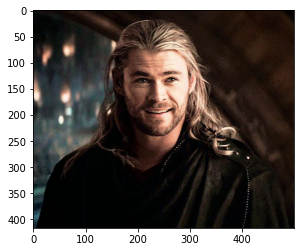

26
he is smiling happy happy happy and 42 years old and the detected gender is male male male male male male male male male male


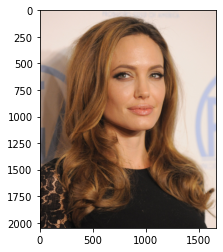

26
the detected face is between 30 and 46 years old and the detected gender is female female female female female female female female female female


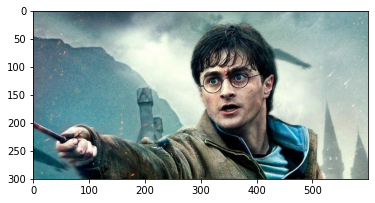

26
the detected face is between 29 and 45 years old and the detected gender is male male male male male male male male male male


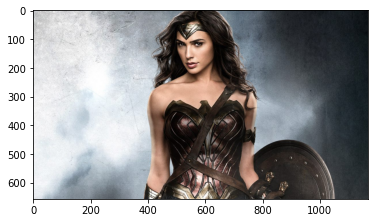

26
the detected face is between 20 and 32 years old and the detected gender is female female female female female female female female female female


In [110]:
#z = 0
#pic = list(encoding_set.keys())[z]

for i in encoding_set.keys():
  imgPath = fpath + i

  image = encoding_set[i].reshape((1,2048))

  x=plt.imread(imgPath)
  plt.imshow(x)
  plt.show()
  caption = greedySearch(image, pic_model)
  print(caption)

In [0]:
#model.load_weights('/content/drive/My Drive/Colab Notebooks/model/LSTM_Caption_Model.h5')

pic_model.save_weights('/content/drive/My Drive/Colab Notebooks/model/Pic_Model_lstm4.h5')